# Imports

In [1]:
import pandas as pd

from sqlalchemy import create_engine

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm

from scipy import stats

# Defining Functions

In [2]:
def sql_query_to_pandas_df(sql_query, 
                           engine, 
                           index_column=None, 
                           dates_column=None):
    """
    Establishes a connection to a SQL database, then sends a SQL query
    to that database, returning the results as a Pandas DataFrame.  Closes
    connection to the database after results are returned.
    
    sql_query (string): a string containing a query in SQL syntax
    
    engine (sql alchemy engine object): Used to establish a connection to the db
    
    index_column (str or list of str): Specifies which column(s) should be set 
    as the index in the Pandas DataFrame that gets returned
    
    dates_column (str or list of str): Specifies which column(s) in the Pandas 
    DataFrame should be parsed as dates
    """
    
    conn = engine.connect()
    
    df=pd.read_sql_query(sql=sql_query, 
                         con=conn, 
                         index_col=index_column,
                         parse_dates=dates_column)
    
    conn.close()
    
    return df

# Question 1
Load the dataset into any database of your choice - MySQL, Postgres, MSSQL, or Oracle - it doesn't matter.

For the SQL code, see q1_cleaning_and_loading_data.sql in the zip file.

# Question 2

In [3]:
# This formats numbers in pandas DataFrames to have commas such that numbers
# are more legible.  Example: 214310 -> 214,310
pd.options.display.float_format = '{:,}'.format

In [4]:
engine = create_engine('postgresql+psycopg2://rancher:@localhost:5430/ohmconnect')

## 2a) How would you summarize the data?  Show summary statistics in one or two tables.  Explain any findings and why you think it's important / relevant.

### Summary Stats - Mean, Std Dev, and Five Number Summary of points

In [5]:
sql_query = """ 
WITH daily_points AS (
  SELECT event_date
       , SUM(points) AS points_per_day
    FROM event_performance
GROUP BY event_date
),

summary_stats AS (
  SELECT ROUND(AVG(points_per_day)
                ) AS avg_tot_pts_per_day
       , ROUND(STDDEV(points_per_day)
                ) AS std_dev_tot_pts_per_day
       , MIN(points_per_day) AS min_event_pts
       , PERCENTILE_CONT(0.25)
           WITHIN GROUP (ORDER BY points_per_day) AS q1_event_pts
       , PERCENTILE_CONT(0.5) 
           WITHIN GROUP (ORDER BY points_per_day) AS median_event_pts
       , PERCENTILE_CONT(0.75) 
           WITHIN GROUP (ORDER BY points_per_day) AS q3_event_pts
       , MAX(points_per_day) AS max_event_pts
    FROM daily_points
    ),
    
row_summary_stats AS (

  SELECT 1 AS num
       , 'num_energy_events' AS statistic
       , COUNT(DISTINCT event_date) AS value
    FROM event_performance
   UNION
  SELECT 2
       , 'num_unique_users'
       , COUNT(userid)
    FROM users
   UNION
  SELECT 3
       , 'participating_users_pct'
       , ROUND((SELECT COUNT(DISTINCT userid) FROM event_performance)::NUMERIC / 
           (SELECT COUNT(userid) FROM users), 4) * 100
   UNION
  SELECT 4 AS num
       , 'avg_tot_pts_per_day'
       , avg_tot_pts_per_day
    FROM summary_stats
   UNION
  SELECT 5
       , 'std_dev_tot_pts_per_day'
       , std_dev_tot_pts_per_day
    FROM summary_stats
   UNION
  SELECT 6
       , 'min_event_pts'
       , min_event_pts
    FROM summary_stats
   UNION
  SELECT 7
       , 'q1_event_pts'
       , q1_event_pts
    FROM summary_stats
   UNION
  SELECT 8
       , 'median_event_pts'
       , median_event_pts
    FROM summary_stats
   UNION
  SELECT 9
       , 'q3_event_pts'
       , q3_event_pts
    FROM summary_stats
   UNION
  SELECT 10
       , 'max_event_pts'
       , max_event_pts
    FROM summary_stats
   UNION
  SELECT 11
       , 'range'
       , max_event_pts - min_event_pts
    FROM summary_stats
  )

  SELECT statistic
       , value
    FROM row_summary_stats
ORDER BY num;
"""

quantitative_summary_stats = sql_query_to_pandas_df(sql_query,
                                                    engine,
                                                    index_column='statistic')

quantitative_summary_stats

,value
statistic,
num_energy_events,147.0
num_unique_users,"1,100.0"
participating_users_pct,89.09
avg_tot_pts_per_day,"49,375.0"
std_dev_tot_pts_per_day,"72,282.0"
min_event_pts,"-257,483.0"
q1_event_pts,"6,272.0"
median_event_pts,"26,713.0"
q3_event_pts,"75,072.5"


**Assumption: Points are a measure of energy consumption with a magnitude corresponding to the amount of energy reduced or consumed.  Negative points indicate a user did not successfully reduce their energy consumption; in other words, the user actually consumed more energy, whereas positive points indicate a user successfully reduced their energy consumption and used less energy.** 

**Under this assumption, a point score of -1,000 means a user would have consumed more energy than someone who scored -100, although both failed to reduce energy consumption, and a point score of 1,000 indicates a user reduced their energy consumption by more than a user with a point score of 100.  Zero points would mean neither an increase nor decrease in the amount of energy consumed, and the user has used the same amount of energy.**

The table above shows summary statistics based on the total number of points earned by all users who participated during an energy event.  The instructions define an energy event as an instance when users are asked to reduce power consumption, however to be more specific, I further define an energy event as a day where OhmConnect requests users to reduce energy consumption.  Under this definition, there were 147 energy events that occurred in this dataset, with 89.09% of all 1,100 unique users participating in at least one energy event.

The average of the total number of points per energy event was 49,375, indicating the typical energy event is effective in reducing power consumption.  However, the standard deviation is large in comparison, sitting at 72,282 points, showing there is a fair bit of variance in energy usage among energy events.  This is further supported by looking at the min and max values, which span from -257,483 to 408,321 points, corresponding to a rather large range of 665,804 points. 

We would expect a majority of energy events to have total points earned within one standard deviation from the mean, or between -22,907 and 121,657 points.  Consequently, there were energy events where the total number of points was negative, and OhmConnect's users did not successfully reduce energy consumption. Despite the large amount of variation, the first quartile for total points earned during an energy event sits at 6,272, meaning at least 75% of energy events successfully reduce power consumption.

It's particularly important to note that the minimum for the total number of points earned in an energy event was -257,483, which will be investigated further later on in the analysis.

**These findings are important because they give a general sense of the health of OhmConnect's business model.  While there is evidence that some energy events are not successful in reducing energy consumption, the initial impression is that most energy events are successful and OhmConnect's users generally do a good job at reducing energy consumption.  Yay OhmConnect!**

### Summary Stats - Frequencies and Relative Frequencies of Attributes

In [6]:
sql_query = """ 
  SELECT attribute1::text AS attribute
       , COUNT(userid) AS freq
       , ROUND(COUNT(userid):: NUMERIC / 
            SUM(COUNT(userid)) OVER (), 4) AS rel_freq
    FROM users
GROUP BY attribute1
UNION
  SELECT attribute2 AS attribute
       , COUNT(userid) AS freq
       , ROUND(COUNT(userid)::NUMERIC / 
            SUM(COUNT(userid)) OVER (), 4) AS rel_freq
    FROM users
GROUP BY attribute2
ORDER BY 1;
"""

sql_query_to_pandas_df(sql_query, engine, index_column='attribute')

,freq,rel_freq
attribute,,
0,899,0.8173
1,201,0.1827
A,411,0.3736
B,445,0.4045
C,244,0.2218


In order to get a high-level understanding of the userbase, it's important to get a sense of what types of users are present.  The table above shows the distribution of users based on their attribute.  Attribute1 is a binary variable of either 0 or 1, while attribute2 is a categorical variable having values A, B, or C.  

From the table, an overwhelming majority of users (\~81%) have the first attribute set to 0.  For the second attribute, the majority of users (\~40%) have an attribute of B; however, a nearly equal amount of users (\~37%) have an attribute of A.

In [7]:
sql_query = """ 
  SELECT attribute1
       , attribute2
       , COUNT(userid) AS freq
       , ROUND(COUNT(userid):: NUMERIC / 
            SUM(COUNT(userid)) OVER (), 4) AS rel_freq
    FROM users
GROUP BY attribute1, attribute2
ORDER BY attribute1, attribute2;
"""

sql_query_to_pandas_df(sql_query, 
                       engine, 
                       index_column=['attribute1', 'attribute2'])

freq  rel_freq
attribute1 attribute2                
0          A            342    0.3109
           B            353    0.3209
           C            204    0.1855
1          A             69    0.0627
           B             92    0.0836
           C             40    0.0364

Digging deeper, it looks like the most common user profile is 0B, with 0A not that far behind.  Overall, users with attribute1 = 1 are far rarer; however, among these users, attribute B is still the most common, with attribute A not far behind.  

**This is important because establishing these user profiles now will be helpful later in understanding which kinds of users may be more or less likely to successfully reduce their energy consumption during an energy event.**

### Summary Stats - Frequences and Relative Frequencies of User Types

In [8]:
sql_query = """
WITH user_types AS (
  SELECT userid, 'total_points_positive' AS user_type
    FROM event_performance
GROUP BY userid
  HAVING SUM(points) > 0
   UNION
  SELECT userid, 'total_points_negative'
    FROM event_performance
GROUP BY userid
  HAVING SUM(points) < 0
   UNION
  SELECT userid, 'total_points_zero'
    FROM event_performance
GROUP BY userid
  HAVING SUM(points) = 0
  )

  SELECT user_type
       , COUNT(user_type) AS num_users
       , ROUND(COUNT(user_type)::NUMERIC / 
           SUM(COUNT(user_type)) OVER (), 4) AS rel_freq
    FROM user_types
GROUP BY user_type
ORDER BY num_users DESC;
"""

sql_query_to_pandas_df(sql_query, engine, index_column='user_type')

,num_users,rel_freq
user_type,,
total_points_positive,700,0.7143
total_points_negative,279,0.2847
total_points_zero,1,0.001


Lastly, to understand user behavior a little better, it might be useful to look at the total number of points per userid for this dataset.  The table above shows a large majority of users (\~71%) where their yearly total number of points earned is positive, while most of the remaining users have yearly point totals that are negative, with one exception.  There's a user whose total points earned are 0. 

**These summary statistics are important as they also give some insight into the success of OhmConnect's business model.  Because 71% of OhmConnect's users have positive point totals, they must be consistently reducing their energy consumption over the course of the year, and broadly speaking, OhmConnect is successful roughly 71% of the time.**

#### Investigating the single user with 0 yearly points

In [9]:
sql_query = """
SELECT *
  FROM event_performance
 WHERE userid = (SELECT userid
                   FROM event_performance
               GROUP BY userid
                 HAVING SUM(points) = 0
                  )
"""

sql_query_to_pandas_df(sql_query, engine)

,userid,event_date,hour,points
0,48a7a9b3-e397-47c4-8fb2-e9f3e71b6db3,2019-07-24,19,0


Nothing too interesting here.  I guess the user participated in just a single energy event and used their typical amount of energy.

## 2b) Show at least 3 visualizations that summarize the data.  Use any open source tool or spreadsheet.  Again, explain your findings and their importance / relevance.

### Exploring By Month

#### Total Points and Total Users Per Month

In [10]:
sql_query = """
  SELECT DATE_TRUNC('month', event_date)::date AS month
       , SUM(points) AS total_points
    FROM event_performance
GROUP BY DATE_TRUNC('month', event_date)::date
ORDER BY 1;
"""

total_points_per_month = sql_query_to_pandas_df(sql_query,
                                                engine,
                                                index_column='month',
                                                dates_column='month')

In [11]:
sql_query = """
  SELECT DATE_TRUNC('month', event_date)::date AS month
       , COUNT(DISTINCT userid) AS total_users
    FROM event_performance
GROUP BY DATE_TRUNC('month', event_date)::date
ORDER BY 1;
"""

total_users_per_month = sql_query_to_pandas_df(sql_query,
                                               engine,
                                               index_column='month',
                                               dates_column='month')

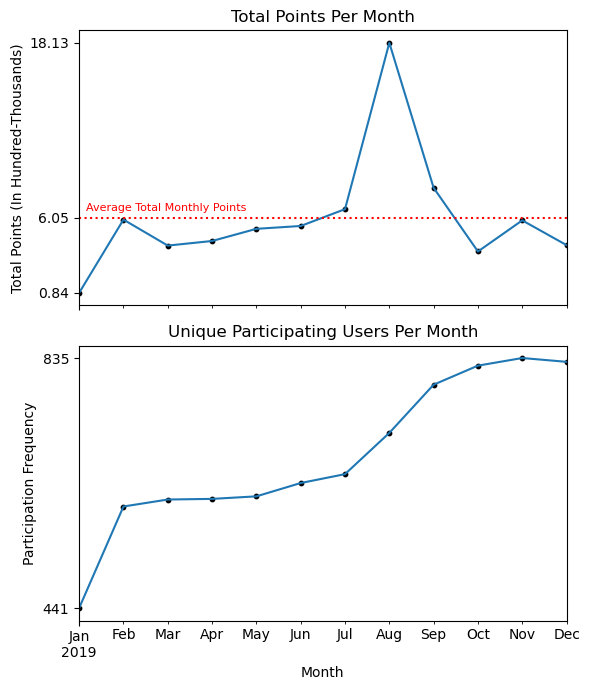

In [12]:
avg_tot_pts_per_month = total_points_per_month.mean().values[0]
min_tot_pts_per_month = total_points_per_month.min().values[0]
max_tot_pts_per_month = total_points_per_month.max().values[0]

avg_tot_users_per_month = total_users_per_month.mean().values[0]
min_tot_users_per_month = total_users_per_month.min().values[0]
max_tot_users_per_month = total_users_per_month.max().values[0]

fig, ax = plt.subplots(2,1, sharex=True, figsize=(6,7))

total_points_per_month.plot(kind='line', legend=False, ax=ax[0])
ax[0].scatter(total_points_per_month.index, total_points_per_month.values, color='black', s=10)

ax[0].set_title('Total Points Per Month')
ax[0].set_xlabel('Month')
ax[0].set_yticks([min_tot_pts_per_month, avg_tot_pts_per_month, max_tot_pts_per_month])
ax[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x)/100_000, 2), ',')))
ax[0].set_ylabel('Total Points (In Hundred-Thousands)')

ax[0].axhline(avg_tot_pts_per_month, linestyle=':', color='red')
ax[0].annotate("Average Total Monthly Points", 
               xy=('2019-01-01',
                   avg_tot_pts_per_month), 
               textcoords="offset points", 
               xytext=(5,5), c='red', fontsize=8, ha='left')


total_users_per_month.plot(kind='line', legend=False, ax=ax[1])
ax[1].scatter(total_users_per_month.index, total_users_per_month.values, color='black', s=10)

ax[1].set_title('Unique Participating Users Per Month')
ax[1].set_xlabel('Month')
ax[1].set_yticks([min_tot_users_per_month, max_tot_users_per_month])
ax[1].set_ylabel('Participation Frequency')

plt.tight_layout();

The first graph shows all months have a sum of points greater than 0, which provides further evidence that overall, users are successfully reducing energy consumption during energy events. Late summer and early fall have the only three months that performed better than average, July, August, and September, with August being the best-performing month by a large margin. 

Looking at the second graph, these late spring and summer months correspond to months where there were some of the largest increases in user participation.  However, there was a large increase in user participation between January and February too.  While February had only roughly average performance, that month saw the second largest increase in total points earned for the entire year.

Outside of these best performing months, total points don't show much variation.  Points earned between February and July remain fairly consistent, which corresponds to the number of participating users stagnating over the same time period.  However, this trend doesn't hold true for the entire year as October, November, and December had the largest number of participating users, yet each of those months had point totals below average and show more variation than is found in February through July.

Lastly, January had the lowest number of participating users all year, which is probably a large contributing factor as to why January also had the lowest point performance.  Interestingly, despite August having the best point performance, it was 5th in terms of participating users.  

**These findings are important for two main reasons:**
1. **Total points earned show some seasonality, and identifying ways to increase user performance during the early spring, late fall, and throughout the winter months could be important to fostering growth and generating revenue.**

2. **Total points earned also shows some connection to number of participating users.  Consequently, identifying why the number of users increased rapidly between January and February at the start of the year, or during the late spring and early summer months, could be important to driving future growth and, in turn, additional revenue.**

#### Total Points Per Month Based on User Type (Users With Positive Point Totals vs. Users With Negative Point Totals)

In [13]:
sql_query = """
WITH users_with_positive_totals AS (
  SELECT userid
    FROM event_performance
GROUP BY userid
  HAVING SUM(points) > 0
  )

SELECT DATE_TRUNC('month', event_date)::date AS month
     , SUM(points) AS total_positive_points
FROM event_performance
WHERE userid IN (SELECT userid FROM users_with_positive_totals)
GROUP BY DATE_TRUNC('month', event_date)
ORDER BY 1;
"""

users_total_positive_points_per_month = \
                                sql_query_to_pandas_df(sql_query,
                                                       engine,
                                                       index_column='month',
                                                       dates_column='month')

In [14]:
sql_query = """
WITH users_with_negative_totals AS (
  SELECT userid
    FROM event_performance
GROUP BY userid
  HAVING SUM(points) < 0
  )

SELECT DATE_TRUNC('month', event_date)::date AS month
     , SUM(points) AS total_negative_points
FROM event_performance
WHERE userid IN (SELECT userid FROM users_with_negative_totals)
GROUP BY DATE_TRUNC('month', event_date)
ORDER BY 1;
"""

users_total_negative_points_per_month = \
                                sql_query_to_pandas_df(sql_query,
                                                       engine,
                                                       index_column='month',
                                                       dates_column='month')

In [15]:
positive_users_min_total = users_total_positive_points_per_month['total_positive_points'].min()

positive_users_max_total = users_total_positive_points_per_month['total_positive_points'].max()

negative_users_min_total = users_total_negative_points_per_month['total_negative_points'].min()

negative_users_max_total = users_total_negative_points_per_month['total_negative_points'].max()

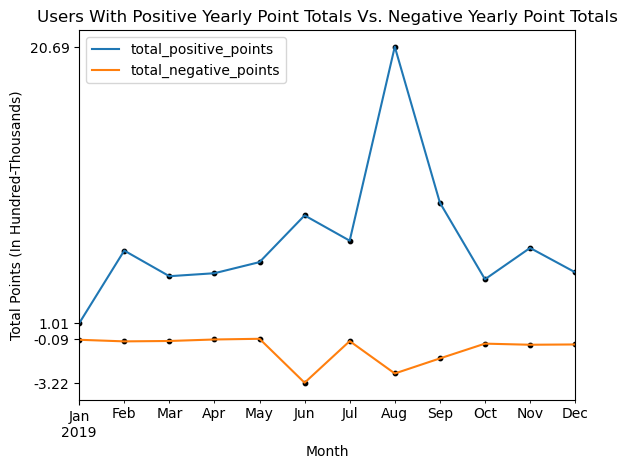

In [16]:
fig, ax = plt.subplots(1,1)

users_total_positive_points_per_month.plot(kind='line', legend=True, ax=ax)

ax.scatter(users_total_positive_points_per_month.index, 
           users_total_positive_points_per_month.values, 
           color='black', s=10)

users_total_negative_points_per_month.plot(kind='line', legend=True, ax=ax)

ax.scatter(users_total_negative_points_per_month.index, 
           users_total_negative_points_per_month.values, 
           color='black', s=10)

ax.set_title('Users With Positive Yearly Point Totals Vs. Negative Yearly Point Totals')

ax.set_xlabel('Month')
ax.set_yticks([negative_users_min_total, 
               negative_users_max_total, 
               positive_users_min_total, 
               positive_users_max_total])

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x)/100_000, 2), ',')))
ax.set_ylabel('Total Points (In Hundred-Thousands)');

The plot above was generated by segmenting users who have a positive total number of points earned over the course of the year from users who have a negative total number of points earned over the course of the year.  In the summary statistics part of this analysis, it was noted that 71% of users had positive yearly point totals, while 29% of users had negative yearly point totals.  

The blue line represents users with positive yearly point totals and closely mimics the previous graph, where the strongest performance tended to occur during the late spring and summer months; however, the orange line represents users with negative yearly point totals and tells a new part of the story.  

While June and August were the worst months in terms of energy consumption for these users, these months are the exception to the rule.  In general, there is little variation in the number of points scored by these users in the remaining months, and their point scores stay fairly consistent.  This lends some evidence that these users are not very energy conscious and tend to use roughly the same amount of energy, regardless of external factors such as time of year, and could be less motivated to conserve energy by OhmConnect's point earning incentives.

To that end, it's interesting to find that June and August have small spikes in point totals where users with negative yearly point totals consume more energy, yet in these same months there are spikes in the opposite direction for users with positive yearly point totals.  Because these months tend to be the hottest of the year, it's strange to see energy consumption going in opposite directions for these different kinds of users, which may offer insight into their behavior.  Perhaps this is further evidence that users with negative yearly point totals are not very energy conscious and will not make attempts to conserve energy during the hotter months, whereas users with positive yearly point totals will.

### Total Points By Season and By Hour

In [17]:
sql_query = """
SELECT userid 
     , event_date
     , hour
     , points
     , CASE
            WHEN EXTRACT(MONTH FROM event_date) IN (3, 4, 5) THEN 'spring'
            WHEN EXTRACT(MONTH FROM event_date) IN (6, 7, 8) THEN 'summer'
            WHEN EXTRACT(MONTH FROM event_date) IN (9, 10, 11) THEN 'fall'
            ELSE 'winter'
        END AS season
  FROM event_performance;
"""

event_performance_with_seasons = sql_query_to_pandas_df(sql_query,
                                                        engine,
                                                        index_column='event_date',
                                                        dates_column='event_date')

In [18]:
event_performance_spring = event_performance_with_seasons[event_performance_with_seasons['season']=='spring']

event_performance_summer = event_performance_with_seasons[event_performance_with_seasons['season']=='summer']

event_performance_fall = event_performance_with_seasons[event_performance_with_seasons['season']=='fall']

event_performance_winter = event_performance_with_seasons[event_performance_with_seasons['season']=='winter']

hourly_point_totals_spring = event_performance_spring.groupby('hour').agg(sum)[['points']]

hourly_point_totals_summer = event_performance_summer.groupby('hour').agg(sum)[['points']]

hourly_point_totals_fall = event_performance_fall.groupby('hour').agg(sum)[['points']]

hourly_point_totals_winter = event_performance_winter.groupby('hour').agg(sum)[['points']]

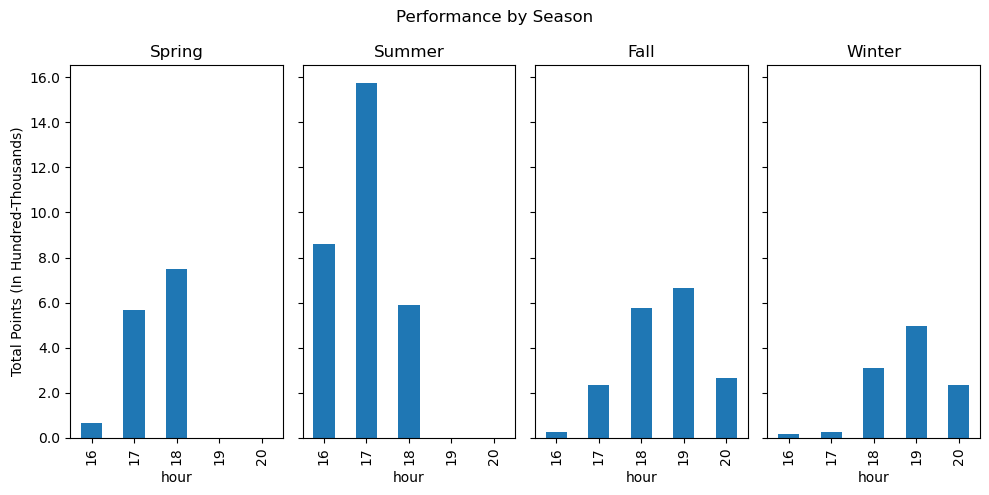

In [19]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10,5))

fig.suptitle('Performance by Season')

hourly_point_totals_spring.plot(kind='bar', legend=False, ax=ax[0])
ax[0].set_title('Spring')
ax[0].set_ylabel('Total Points (In Hundred-Thousands)')
ax[0].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x)/100_000, 2), ',')))

hourly_point_totals_summer.plot(kind='bar', legend=False, ax=ax[1])
ax[1].set_title('Summer')

hourly_point_totals_fall.plot(kind='bar', legend=False, ax=ax[2])
ax[2].set_title('Fall')

hourly_point_totals_winter.plot(kind='bar', legend=False, ax=ax[3])
ax[3].set_title('Winter')

plt.tight_layout();

Because it was noticed earlier that total points earned per month showed some seasonality, it's worth looking at performance for each season, spring, summer, fall, and winter.

The graph above shows hourly totals of points earned for each season and reveals a few interesting things.  To begin, energy events only occur in the evening hours, starting as early as hour 16 and going as late as hour 20.  In spring and summer, the general trend is that more points are earned in earlier hours, while in fall and winter, more points are earned in later hours.  Furthermore, spring and summer have no points earned during hours 19 and 20, yet in fall and winter, most points are earned in hour 19. Regardless of the season, the trend is that more points are earned hour by hour until reaching a peak, and then points earned steadily decline afterwards.

**This is important to know because this information can be used to target energy events during times of the day that will see more user engagement and more points earned based on the season.  In spring and summer, earlier hours should be preferred, whereas in fall and winter, later hours should be preferred.**

### Total Points Per Energy Event

In [20]:
sql_query = """
  SELECT DATE_TRUNC('day', event_date)::date AS day
       , SUM(points) AS total_points
    FROM event_performance
GROUP BY DATE_TRUNC('day', event_date)::date
ORDER BY 1;
"""

total_points_per_day = sql_query_to_pandas_df(sql_query,
                                              engine,
                                              index_column='day',
                                              dates_column='day')

In [21]:
sql_query = """
WITH total_points_per_day AS (
  SELECT DATE_TRUNC('day', event_date)::date AS day
       , SUM(points) AS total_points
    FROM event_performance
GROUP BY DATE_TRUNC('day', event_date)::date
)

  SELECT day
       , total_points
    FROM total_points_per_day
   WHERE total_points = (SELECT MIN(total_points) FROM total_points_per_day)
      OR total_points = (SELECT MAX(total_points) FROM total_points_per_day);
"""

extreme_points_days = sql_query_to_pandas_df(sql_query,
                                             engine,
                                             index_column='day',
                                             dates_column='day')

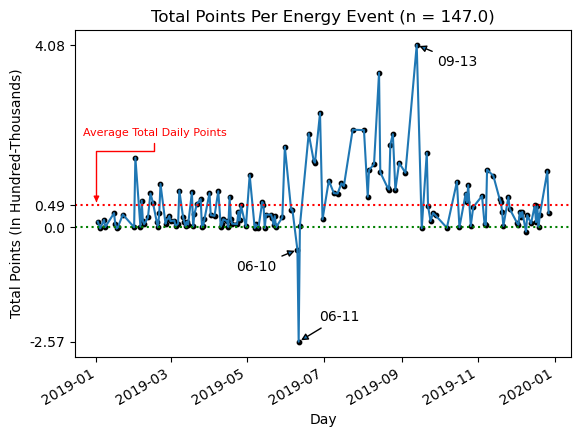

In [22]:
num_energy_events = quantitative_summary_stats.loc['num_energy_events'][0]

min_day = extreme_points_days.index.strftime('%m-%d').values[0]
max_day = extreme_points_days.index.strftime('%m-%d').values[1]

min_total_pts_per_day = extreme_points_days['total_points'][0]
max_total_pts_per_day = extreme_points_days['total_points'][1]

avg_tot_pts_per_day = total_points_per_day.mean().values[0]

fig, ax = plt.subplots(1,1)

total_points_per_day.plot(kind='line', legend=False, ax=ax)
ax.scatter(total_points_per_day.index, total_points_per_day.values, color='black', s=10)

ax.set_title(f'Total Points Per Energy Event (n = {num_energy_events})')
ax.set_xlabel('Day')
ax.set_yticks([min_total_pts_per_day, 0, avg_tot_pts_per_day, max_total_pts_per_day])
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x)/100_000, 2), ',')))
ax.set_ylabel('Total Points (In Hundred-Thousands)')

ax.axhline(avg_tot_pts_per_day, linestyle=':', color='red')
ax.axhline(0, linestyle=':', color='green')

ax.annotate("Average Total Daily Points", 
            xy=('2019-01-01', avg_tot_pts_per_day), 
            xytext=(-10,50), 
            textcoords="offset points", 
            c='red', 
            fontsize=8, 
            ha='left', 
            arrowprops=dict(arrowstyle='-|>', 
                            color='red', 
                            connectionstyle="bar,angle=180, fraction=-0.2"))

ax.annotate(f'{min_day}', 
            xy=(extreme_points_days.index[0], 
                extreme_points_days.values[0]), 
            xytext=(15, 15), 
            textcoords='offset points', 
            arrowprops=dict(arrowstyle='-|>'))
ax.annotate(f'06-10', 
            xy=('2019-06-10', -51051), 
            xytext=(-15, -15), 
            textcoords='offset points',
            ha='right', 
            arrowprops=dict(arrowstyle='-|>'))
ax.annotate(f'{max_day}', 
            xy=(extreme_points_days.index[1], 
                extreme_points_days.values[1]), 
            xytext=(15, -15), 
            textcoords='offset points', 
            arrowprops=dict(arrowstyle='-|>'));

The graph above shows the total points earned for each of the 147 energy events present in the dataset.  The vast majority of points lie above 0, further confirming what was seen earlier, most energy events are successful in reducing energy consumption.  However, many of these points are below average and are therefore only moderately successful in doing so.  

On the other hand, virtually all energy events found during the months of June through September have above average performance, with the most successful day of the year happening on September 13th.  This isn't too surprising, as it was found earlier in the analysis that the late spring and summer months had the best performance throughout the year.  

In question 2a), it was noted that one day had the worst performance with -257,483 points earned, which appears to correspond to July 11th.  Furthermore, the second worst performing day of the year occurs on July 10th.  I would guess this dataset comes from the west coast, and if so, the terrible performance on both days is likely due to an [extreme heatwave](https://www.usatoday.com/story/news/nation/2019/06/11/heat-wave-western-us-bakes-temperatures-soar-120-degrees/1419639001/) happening during those times.

**These observations are important for two reasons:**
1. **They further reinforce the idea that increasing user participation and user performance outside of late spring and summer is important to foster growth and generate revenue.**
2. **While late spring and summer months consistently perform well, energy conservation is completely nonexistent during a heatwave, and thus energy events should be avoided at all costs during these times.**

## 2c/d) Show Information about the top two performers by month in a table.  Your table must contain 24 rows - two rows for the top two performers in each month.  Provide the SQL you used to derive the table.

In [23]:
sql_query = """
WITH points_rankings AS (
	  SELECT userid
	       , EXTRACT(MONTH FROM event_date) AS month
	       , SUM(points) AS points_earned
	       , DENSE_RANK() OVER (PARTITION BY EXTRACT(MONTH FROM event_date) 
	     					  ORDER BY SUM(points) DESC
	     					  ) AS ranking
	    FROM event_performance
	GROUP BY userid, EXTRACT(MONTH FROM event_date)
	)

      SELECT userid
           , month
           , points_earned
           , ranking
        FROM points_rankings
       WHERE ranking <= 2
    ORDER BY month, ranking;
"""

top_2_performers_per_month = sql_query_to_pandas_df(sql_query,
                                                    engine)

top_2_performers_per_month

,userid,month,points_earned,ranking
0,2d172cc1-15b2-4442-9fa6-82b30d77683d,1.0,4505,1
1,c146f69c-bffb-44dc-84bd-faf9360144cd,1.0,3403,2
2,424fc967-5e61-4e77-afd8-619b03cec9e4,2.0,15006,1
3,2f88e915-6a2a-4023-ab33-3c5923f54125,2.0,13747,2
4,dd77d0a4-c35c-4e36-867f-339d4f114c2e,3.0,9608,1
5,8009bd3a-2c2c-465e-b7cb-7e051d399572,3.0,9042,2
6,87898b2b-bd3a-4702-ad6e-f259b39796f5,4.0,11899,1
7,dd77d0a4-c35c-4e36-867f-339d4f114c2e,4.0,11095,2
8,dd77d0a4-c35c-4e36-867f-339d4f114c2e,5.0,18418,1
9,2d172cc1-15b2-4442-9fa6-82b30d77683d,5.0,11017,2


## 2e) Answer the following, **clearly stating your assumptions**:
1.  Is there any correlation between user attributes and points earned?  How certain are you about the correlation?
2.  What else can you infer from the table?

### Assumptions

1. The correlation we're interested in is between user attributes and yearly points earned.
2. If a userid is found in the users table but not in the event performance table, that's because that userid never participated in an energy event and thus has scored 0 points for the year.

### Joining Tables

In [24]:
sql_query = """
WITH total_points_per_user AS (
   SELECT userid
        , SUM(points) AS total_points
     FROM event_performance
 GROUP BY userid
  )

   SELECT u.userid
        , u.attribute1
        , u.attribute2
        , COALESCE(tp.total_points, 0) AS total_points
     FROM users AS u
LEFT JOIN total_points_per_user AS tp
       ON u.userid = tp.userid;
"""

users_attributes_and_tot_points = sql_query_to_pandas_df(sql_query,
                                                         engine)

### Checking Correlation

#### Visualizing Correlation

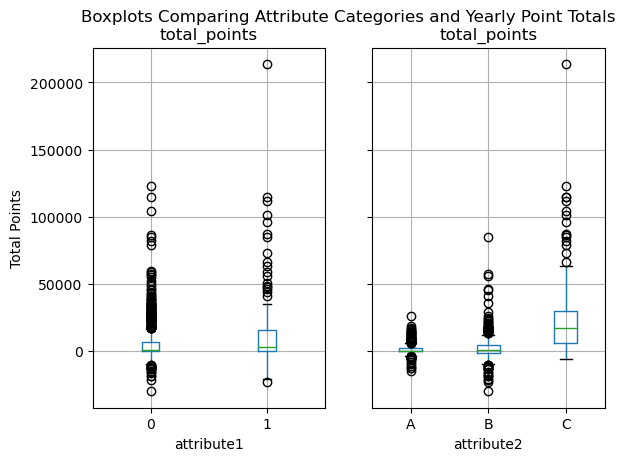

In [25]:
fig, ax = plt.subplots(1, 2, sharey=True)

users_attributes_and_tot_points.boxplot('total_points', by='attribute1', ax=ax[0])
ax[0].set_ylabel('Total Points')

users_attributes_and_tot_points.boxplot('total_points', by='attribute2', ax=ax[1])

fig.suptitle('Boxplots Comparing Attribute Categories and Yearly Point Totals');

The boxplot of attribute1 shows roughly the same spread of point totals regardless of whether attribute1 is set to 0 or 1.  Based on the first boxplot, my initial impression is that there's either no correlation or a weak correlation between attribute1 and yearly point totals.

On the other hand, the second boxplot shows more noticeable differences between levels A, B, and C of attribute2.  Category C looks to be the strongest performing group, with very few users earning a negative amount of points; therefore, most of these users are consistently reducing energy consumption year round.  Category A and category B have roughly similar performance; however, category B is a little more spread out and has more extreme values on both the positive and negative sides. Based on the second boxplot, there appears to be a moderate correlation between attribute2 and yearly point totals.

#### Attribute1

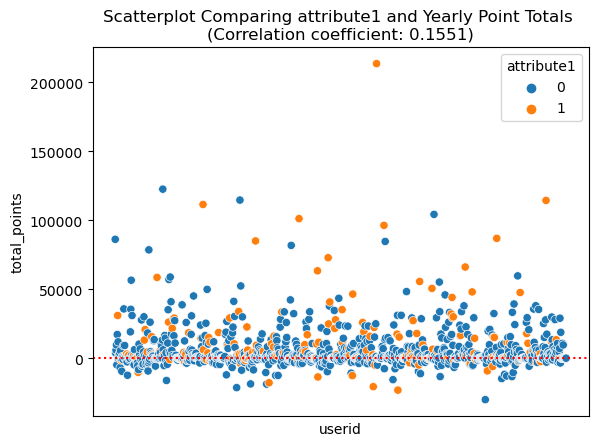

In [26]:
corr=users_attributes_and_tot_points['total_points'].corr(users_attributes_and_tot_points['attribute1'])

ax = sns.scatterplot(x=users_attributes_and_tot_points.index,
                     y='total_points',
                     data=users_attributes_and_tot_points,
                     hue='attribute1')
ax.axhline(y=0, linestyle=':', color='red')
ax.set_xticks([])
ax.set_xlabel('userid')

ax.set_title(f'Scatterplot Comparing attribute1 and Yearly Point Totals \n(Correlation coefficient: {corr:.4f})');

Each dot in the scatterplot above represents a unique userid and their yearly point total.  Most dots are clustered together above or below 0, and there doesn't appear to be any noticeable pattern.  Because 81% of users have attribute1 = 0, most of the dots are blue, but there are good amounts of both orange and blue points in the higher point totals, as well as the lower point totals, and there isn't much evidence that one type of user will score much differently from the other.  Everything here confirms what was seen in the box plot earlier: there doesn't seem to be much correlation between attribute1 and points earned.  

Since both attribute1 and total points are quantitative, Pearson's correlation coefficient can be calculated. The correlation coefficient is 0.1551, indicating a weak correlation; however, this could be true of our sample data and not necessarily true in the greater population.  To check, a t-test must be performed.

In [27]:
X = users_attributes_and_tot_points.loc[:, ['attribute1']]
X = sm.add_constant(X)
y = users_attributes_and_tot_points.loc[:, ['total_points']]

linear_model_attribute1 = sm.OLS(y, X).fit()

In [28]:
attribute1_summary_results = linear_model_attribute1.conf_int()

attribute1_summary_results.rename(mapper={0:'95%_conf_int_lower', 
                                          1:'95%_conf_int_upper'}, 
                                  axis=1, inplace=True)

attribute1_summary_results['pvalues'] = linear_model_attribute1.pvalues
attribute1_summary_results['coefficients'] = linear_model_attribute1.params

attribute1_summary_results = attribute1_summary_results[['coefficients', 
                                                         'pvalues', 
                                                         '95%_conf_int_lower', 
                                                         '95%_conf_int_upper']]

round(attribute1_summary_results.loc[['attribute1']], 4)

,coefficients,pvalues,95%_conf_int_lower,95%_conf_int_upper
attribute1,"6,684.8246",0.0,"4,163.9272","9,205.7219"


##### Peforming a t-test

$H_0:$ There is no significant correlation between attribute1 and total_points

$H_a:$ There is a significant correlation between attribute1 and total_points

At the $\alpha=0.05$ level of significance, the P-value is ~0 and the null hypothesis should be rejected.  This indicates there is sufficient evidence to conclude that attribute1 is statistically significant when predicting total points.  

The summary output from above shows that the coefficient for attribute1 is 6684.8246, meaning that on average, someone who has attribute1 = 1 will earn 6684.8246 points more than someone with attribute1 = 0.  We are 95% confident that the true increase in points earned for those with attribute1 = 1 is between 4163.9272 and 9205.7219 points. 

##### Checking Assumptions of Linear Regression to Determine Validity of the Results

In order for the results from linear regression to be valid, four main conditions must be met:
    
1. Linearity: The relationship between X and Y must be linear.
2. Independence of Errors: There is no relationship between the residuals and the fitted (predicted) Y variable.
3. Normality of Errors: The residuals must be approximately normally distributed.
4. Equal Variances: The variance of the residuals is the same across all values of X.

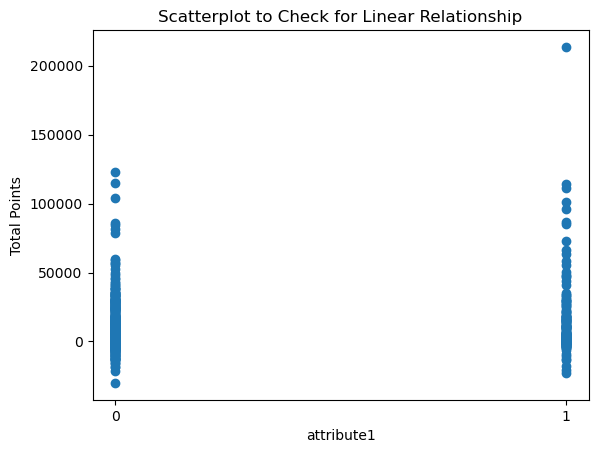

In [29]:
fig, ax = plt.subplots(1,1)

ax.scatter(users_attributes_and_tot_points['attribute1'], 
           users_attributes_and_tot_points['total_points'])

ax.set_title('Scatterplot to Check for Linear Relationship')
ax.set_xlabel('attribute1')
ax.set_xticks([0,1])
ax.set_ylabel('Total Points');

The scatter plot doesn't show any indication that the first assumption is violated.  A linear model could be reasonable for this relationship.

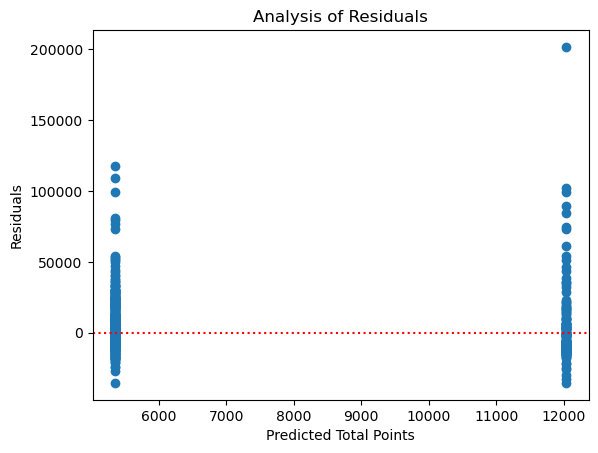

In [30]:
preds = linear_model_attribute1.predict(X)
residuals = users_attributes_and_tot_points['total_points'] - preds

fig, ax = plt.subplots(1,1)

ax.scatter(preds, residuals)
ax.axhline(0, color='red', linestyle=':')
ax.set_xlabel('Predicted Total Points')
ax.set_ylabel('Residuals')
ax.set_title('Analysis of Residuals');

The residual plot doesn't show any indication that the second or fourth assumption is violated.  Because all points are scattered above and below 0, there's no systematic pattern in the residuals and the plot doesn't show any relationship between residuals and total points (second assumption).  Furthermore, the spread across all residuals is roughly the same and therefore the variance of the residuals is roughly the same (fourth assumption).

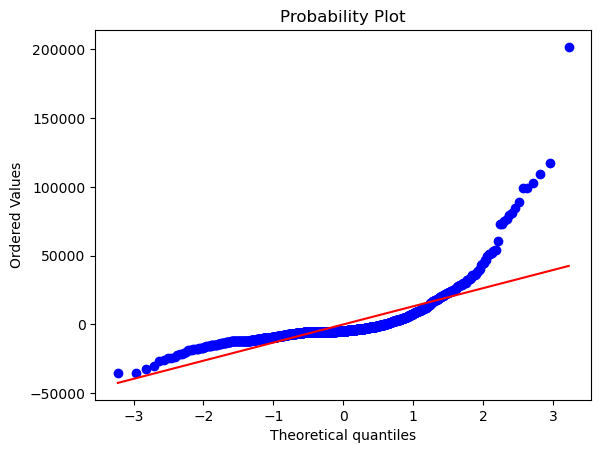

In [31]:
stats.probplot(residuals, plot=plt);

Most of the data points lie close to the straight line; however, there is slight curving, particularly on the right side.  This indicates that the residuals may not be normally distributed, which violates the third assumption.

All of the assumptions except for the assumption of normal residuals seem valid, and therefore the conclusion that a correlation exists between attribute1 and total points earned is still reasonable, although it should be taken with a grain of salt.

#### Attribute2

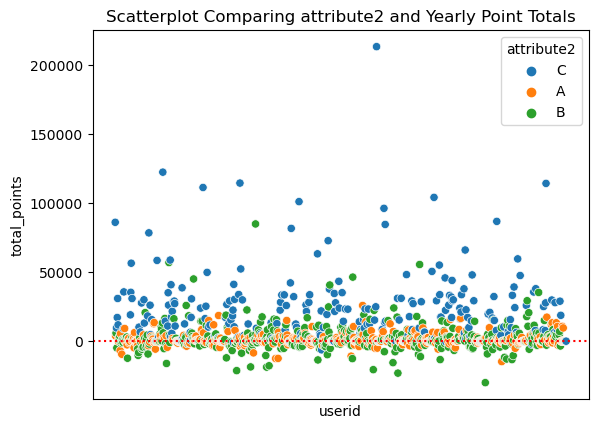

In [32]:
ax = sns.scatterplot(x=users_attributes_and_tot_points.index,
                     y='total_points',
                     data=users_attributes_and_tot_points,
                     hue='attribute2')
ax.axhline(y=0, linestyle=':', color='red')
ax.set_title('Scatterplot Comparing attribute2 and Yearly Point Totals')
ax.set_xticks([])
ax.set_xlabel('userid');

Each dot in the scatterplot above represents a unique userid and their yearly point total, which further sheds light on the patterns identified in the box plots from earlier.

Firstly, nearly all users with attribute2 = C have positive yearly totals, and these users tend to have the best performance.  Users with attribute2 = A are clustered close to 0 and have a tendency to have either slightly above or below 0 total points.  In comparison, most users with attribute2 = B are also clustered close to 0, but are a little more spread out and show more variation in point totals.  

Since attribute2 is categorical, Pearson's correlation coefficient can't be computed at the moment; however, a One Way ANOVA test can be performed to determine if a correlation exists.

##### Performing a One Way ANOVA test

In [33]:
attribute2_lists = users_attributes_and_tot_points.groupby('attribute2')['total_points'].apply(list)

anova_results = stats.f_oneway(*attribute2_lists)

print(f'P-Value: {anova_results.pvalue:.4f}')

P-Value: 0.0000


$H_0$: Attribute2 and total yearly points are not correlated

$H_a$: Attribute2 and total yearly points are correlated

At the $\alpha=0.05$ level of significance, the P-value is ~0 and the null hypothesis should be rejected.  This indicates there is sufficient evidence to conclude that attribute2 is correlated with yearly point totals.

One downside to this test is that it doesn't indicate which level(s) of attribute2 are most correlated with total points earned; however, we can encode attribute2 using dummy variables and check the strength of the correlation that way. 

##### Dummy variables and quantifying correlation

In [34]:
dummy_df = pd.get_dummies(users_attributes_and_tot_points, columns=['attribute2'], dtype=float)

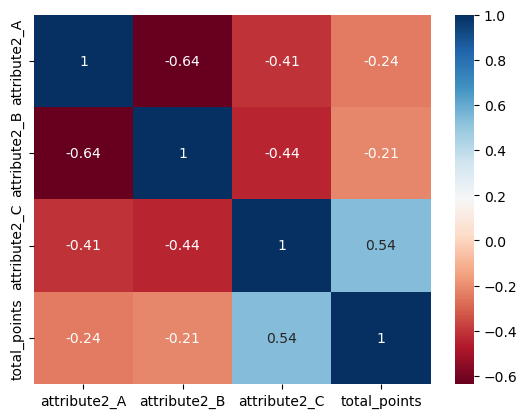

In [35]:
correlations = dummy_df[['attribute2_A', 'attribute2_B', 'attribute2_C', 'total_points']].corr()

sns.heatmap(correlations, annot=True, cmap='RdBu');

A simple heatmap shows that both levels A and B have weak/moderate negative correlations with total points earned, -0.24 and -0.21, respectively, although attribute A is slightly more negatively correlated.  On the other hand, level C has a moderately positive correlation with total points earned of 0.54.

In [36]:
X = dummy_df.loc[:, ['attribute2_B', 'attribute2_C']]
X = sm.add_constant(X)
y = dummy_df.loc[:, ['total_points']]

linear_model_attribute2 = sm.OLS(y, X).fit()

In [37]:
attribute2_summary_results = linear_model_attribute2.conf_int()

attribute2_summary_results.rename(mapper={0:'95%_conf_int_lower', 
                                          1:'95%_conf_int_upper'}, 
                                  axis=1, inplace=True)

attribute2_summary_results['pvalues'] = linear_model_attribute2.pvalues
attribute2_summary_results['coefficients'] = linear_model_attribute2.params

attribute2_summary_results = attribute2_summary_results[['coefficients', 
                                                         'pvalues', 
                                                         '95%_conf_int_lower', 
                                                         '95%_conf_int_upper']]

round(attribute2_summary_results.loc[['attribute2_B', 'attribute2_C']], 4)

,coefficients,pvalues,95%_conf_int_lower,95%_conf_int_upper
attribute2_B,899.8972,0.35,-988.3946,"2,788.1891"
attribute2_C,"21,973.6579",0.0,"19,742.9743","24,204.3415"


In order to avoid the dummy variable trap, regression has to be performed using all but one level of attribute2, which acts as the baseline level for comparison.  In this model, attribute2 = A represents the baseline level, and any coefficients of the model must be interpreted relative to level A.

The summary output above shows the P-value for level B is 0.35, meaning that there is no significant correlation between attribute2 = B and total points earned.  However, the P-value for level C is ~0 and attribute2 = C is a statistically significant predictor.  

The coefficient for level C is 21,973.6579 points.  This means that on average, a user with attribute2 = C will earn 21,973.6579 points more than a user at the baseline level of attibute2 (attribute2 = A).  We are 95% confident that those with attribute2 = C will earn between 19,742.9743 and 24,204.3415 points more than users at baseline level A.

# The End